In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# upload to google drive
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import os
import skimage.io as sk
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import spatial
from tqdm import tqdm

from PIL import Image
from random import shuffle
import cv2


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

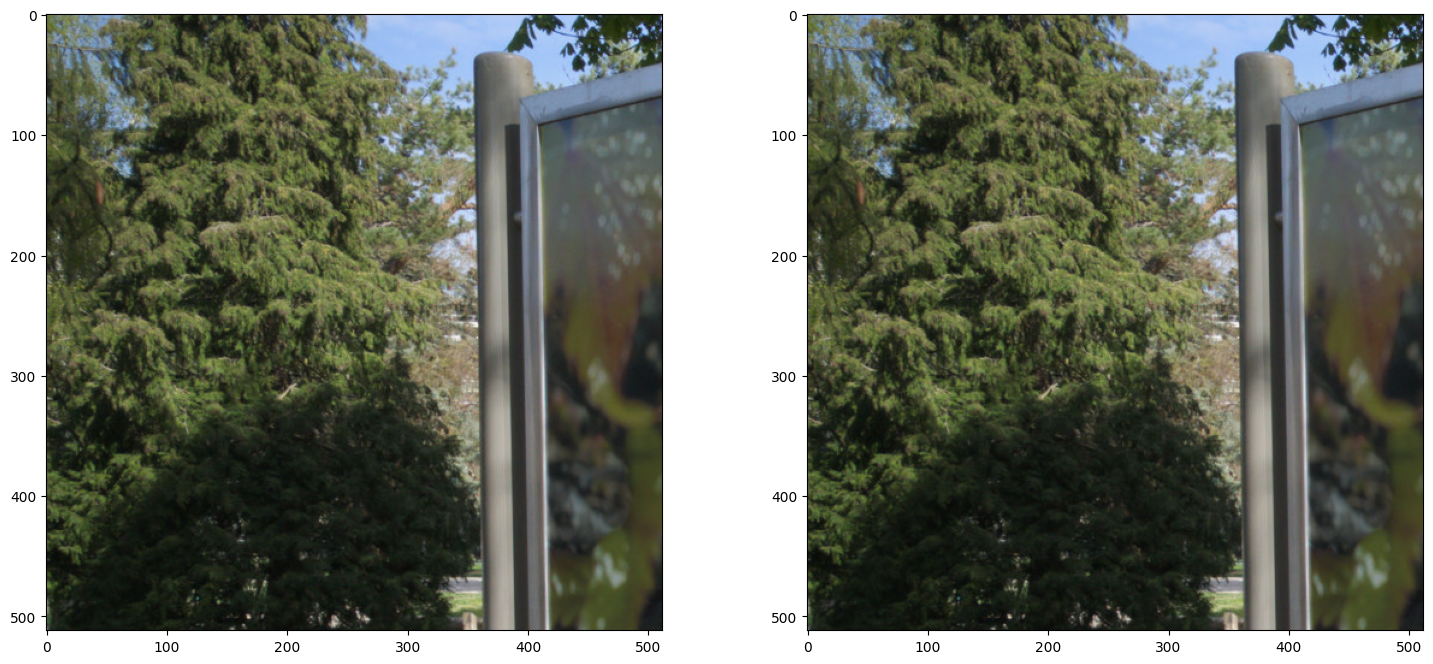

In [4]:
# working on a image with hidden information

img1 = sk.imread("/kaggle/input/alaska2-image-steganalysis/JMiPOD/00001.jpg")
img2 = sk.imread("/kaggle/input/alaska2-image-steganalysis/Cover/00001.jpg")

fig,ax = plt.subplots(1,2,figsize=(18,8))
    
ax[0].imshow(img1)
ax[1].imshow(img2)

In [5]:
# Define paths for the dataset
BASE_PATH = "/kaggle/input/alaska2-image-steganalysis"

In [6]:
import cv2
import binascii
import re
from tqdm import tqdm

In [7]:
# Create a directory for outputs
os.makedirs("extracted_outputs", exist_ok=True)

In [9]:
# Select image paths for analysis
stego_path = os.path.join(BASE_PATH, 'JMiPOD', '00001.jpg')
cover_path = os.path.join(BASE_PATH, 'Cover', '00001.jpg')
print(f"Analyzing stego image: {os.path.basename(stego_path)}")
print(f"Using cover image: {os.path.basename(cover_path)}")

Analyzing stego image: 00001.jpg
Using cover image: 00001.jpg


In [12]:
# Extract DCT coefficients using OpenCV
# Convert images to grayscale for DCT analysis
stego_gray = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2GRAY)
cover_gray = cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2GRAY)

In [13]:
# Apply DCT to 8x8 blocks
h, w = stego_gray.shape
stego_dct_coeffs = np.zeros_like(stego_gray, dtype=float)
cover_dct_coeffs = np.zeros_like(cover_gray, dtype=float)

for i in range(0, h-8, 8):
    for j in range(0, w-8, 8):
        stego_block = stego_gray[i:i+8, j:j+8].astype(float)
        cover_block = cover_gray[i:i+8, j:j+8].astype(float)
        
        stego_dct_coeffs[i:i+8, j:j+8] = cv2.dct(stego_block)
        cover_dct_coeffs[i:i+8, j:j+8] = cv2.dct(cover_block)

In [14]:
# Compute the difference between DCT coefficients
dct_diff = stego_dct_coeffs - cover_dct_coeffs

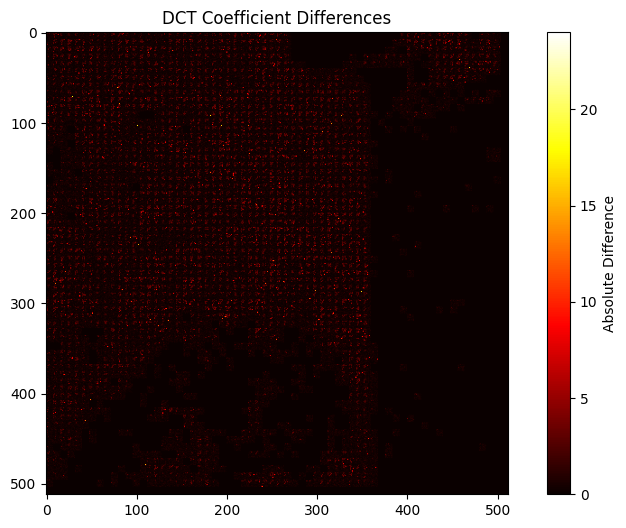

In [15]:
# Visualize the difference
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(dct_diff), cmap='hot')
plt.colorbar(label='Absolute Difference')
plt.title('DCT Coefficient Differences')
plt.savefig('dct_differences.png')
plt.show()

In [16]:
# Compute histograms of the coefficients
stego_flat = stego_dct_coeffs.flatten()
cover_flat = cover_dct_coeffs.flatten()
diff_flat = dct_diff.flatten()

In [17]:
# Filter only for significant coefficients
significant_indices = np.abs(diff_flat) > 1e-10
significant_diffs = diff_flat[significant_indices]

print(f"Number of modified DCT coefficients: {len(significant_diffs)}")

Number of modified DCT coefficients: 162398


In [18]:
# Count positive vs negative changes
positive_changes = np.sum(significant_diffs > 0)
negative_changes = np.sum(significant_diffs < 0)

print(f"Positive changes: {positive_changes}")
print(f"Negative changes: {negative_changes}")

Positive changes: 81292
Negative changes: 81106


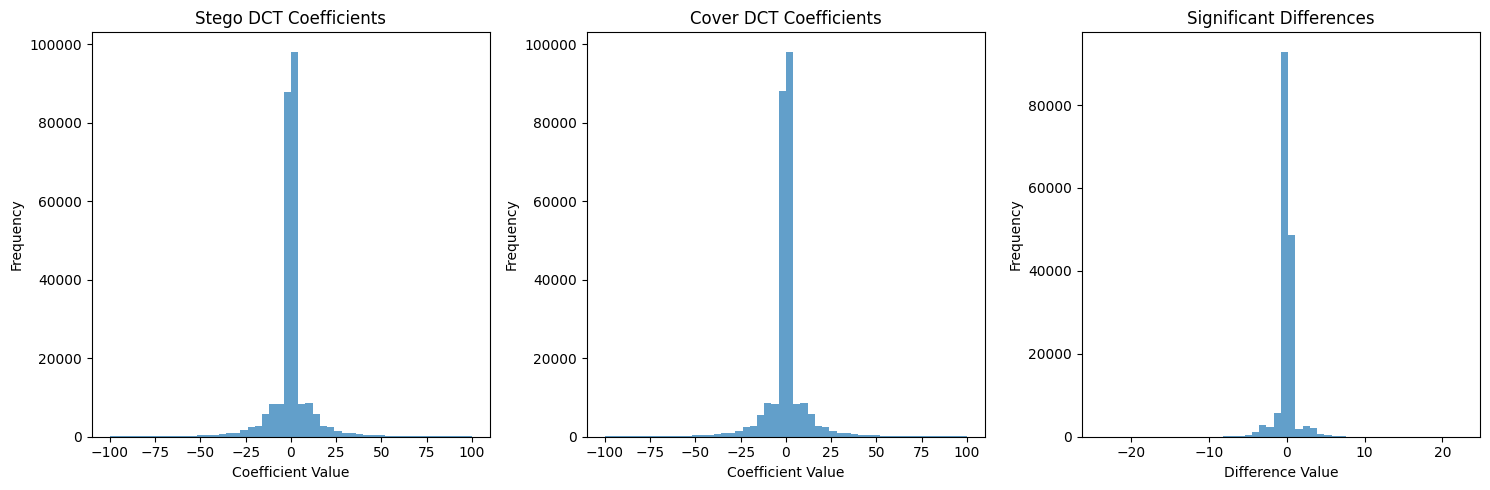

In [19]:
# Visualize histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(stego_flat, bins=50, alpha=0.7, range=(-100, 100))
plt.title('Stego DCT Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(cover_flat, bins=50, alpha=0.7, range=(-100, 100))
plt.title('Cover DCT Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(significant_diffs, bins=50, alpha=0.7)
plt.title('Significant Differences')
plt.xlabel('Difference Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('dct_histograms.png')
plt.show()

In [20]:
# Extract messages using different methods
#--------------------------------------------

# Method 1: Extract LSB from DCT coefficients of Stego image
# We'll focus on the non-zero AC coefficients in each 8x8 block
extracted_bits_method1 = []

for i in range(0, h-8, 8):
    for j in range(0, w-8, 8):
        block = stego_dct_coeffs[i:i+8, j:j+8]
        # Skip the DC coefficient (0,0)
        for ii in range(8):
            for jj in range(8):
                if (ii != 0 or jj != 0) and abs(block[ii, jj]) > 0.1:  # AC coefficient with value
                    # Extract LSB from integer part
                    bit = int(abs(block[ii, jj])) % 2
                    extracted_bits_method1.append(bit)

# Method 2: Extract based on the sign of changes
extracted_bits_method2 = []

# Use the sign of significant differences
for diff in significant_diffs:
    bit = 1 if diff > 0 else 0
    extracted_bits_method2.append(bit)

# Method 3: Extract bits only from specific areas
# Focus on high-frequency coefficients in the lower-right of each 8x8 block
extracted_bits_method3 = []

for i in range(0, h-8, 8):
    for j in range(0, w-8, 8):
        block = stego_dct_coeffs[i:i+8, j:j+8]
        # Use only coefficients in lower-right corner
        for ii in range(4, 8):
            for jj in range(4, 8):
                if abs(block[ii, jj]) > 0.1:
                    bit = int(abs(block[ii, jj])) % 2
                    extracted_bits_method3.append(bit)

print(f"Method 1: Extracted {len(extracted_bits_method1)} bits")
print(f"Method 2: Extracted {len(extracted_bits_method2)} bits")
print(f"Method 3: Extracted {len(extracted_bits_method3)} bits")

Method 1: Extracted 204066 bits
Method 2: Extracted 162398 bits
Method 3: Extracted 46773 bits


In [22]:
# Convert bits to bytes
def bits_to_bytes(bits):
    bytes_array = bytearray()
    for i in range(0, len(bits) - 7, 8):
        byte = 0
        for j in range(8):
            if i + j < len(bits):
                byte = (byte << 1) | bits[i + j]
        bytes_array.append(byte)
    return bytes(bytes_array)

In [23]:
# Process all methods
extracted_bytes_method1 = bits_to_bytes(extracted_bits_method1)
extracted_bytes_method2 = bits_to_bytes(extracted_bits_method2)
extracted_bytes_method3 = bits_to_bytes(extracted_bits_method3)

In [24]:
# Save the extracted data
with open("extracted_outputs/method1_data.bin", "wb") as f:
    f.write(extracted_bytes_method1)

with open("extracted_outputs/method2_data.bin", "wb") as f:
    f.write(extracted_bytes_method2)

with open("extracted_outputs/method3_data.bin", "wb") as f:
    f.write(extracted_bytes_method3)

In [25]:
# Analyze the extracted data
for method_num, data in enumerate([extracted_bytes_method1, extracted_bytes_method2, extracted_bytes_method3], 1):
    print(f"\nAnalyzing Method {method_num} data:")
    
    # Limit analysis to first 1000 bytes
    analysis_data = data[:1000]
    
    # Try to interpret as text
    try:
        text = analysis_data.decode('utf-8', errors='replace')
        printable_ratio = sum(c.isprintable() or c.isspace() for c in text) / len(text)
        
        print(f"Text interpretation ratio: {printable_ratio:.2f}")
        
        if printable_ratio > 0.7:
            print("Text sample (first 100 chars):")
            print(text[:100])
            
            # Save text to file
            with open(f"extracted_outputs/method{method_num}_text.txt", "w", encoding="utf-8") as f:
                f.write(text)
    except:
        print("Failed to interpret as text")
    
    # Check for patterns
    byte_counts = {}
    for byte in analysis_data:
        if byte in byte_counts:
            byte_counts[byte] += 1
        else:
            byte_counts[byte] = 1
    
    # Calculate entropy
    total_bytes = len(analysis_data)
    entropy = 0
    for count in byte_counts.values():
        probability = count / total_bytes
        entropy -= probability * np.log2(probability)
    
    print(f"Entropy: {entropy:.4f}")
    print(f"Unique bytes: {len(byte_counts)}")
    
    # Hexdump of first 32 bytes
    hex_dump = binascii.hexlify(analysis_data[:32]).decode('ascii')
    print(f"Hex dump (first 32 bytes): {' '.join(hex_dump[i:i+2] for i in range(0, len(hex_dump), 2))}")
    
    # Look for known patterns
    common_markers = {
        'jpeg_start': b'\xff\xd8\xff',
        'png_start': b'\x89PNG',
        'pdf_start': b'%PDF',
        'html_start': b'<!DOCTYPE',
        'xml_start': b'<?xml',
        'json_start': b'{',
        'text': b'text',
        'image': b'image',
        'data': b'data',
        'file': b'file',
        'secret': b'secret',
        'hidden': b'hidden',
        'message': b'message'
    }
    
    print("Searching for known patterns...")
    found_markers = False
    
    for name, marker in common_markers.items():
        if marker in analysis_data:
            print(f"Found '{name}' marker at position {analysis_data.find(marker)}")
            found_markers = True
    
    if not found_markers:
        print("No common markers found")


Analyzing Method 1 data:
Text interpretation ratio: 0.52
Entropy: 5.6848
Unique bytes: 183
Hex dump (first 32 bytes): 48 07 a3 86 80 08 00 41 81 05 86 03 02 00 d1 c2 43 80 00 00 09 35 10 30 68 42 00 36 01 16 8c 08
Searching for known patterns...
No common markers found

Analyzing Method 2 data:
Text interpretation ratio: 0.90
Text sample (first 100 chars):
�OM���Ot]	 ��`��=^0*7�P&���PN�����?��Ȣ;8�0.�	)�v�'�B@8x
Entropy: 7.8205
Unique bytes: 251
Hex dump (first 32 bytes): 2f 82 ea a2 79 34 fa 44 d0 17 49 55 4f ea 4d 91 9c 7e 5c b0 9a df e0 a1 7d ae 70 1b f8 26 1d 45
Searching for known patterns...
Found 'json_start' marker at position 556

Analyzing Method 3 data:
Text interpretation ratio: 0.09
Entropy: 1.4456
Unique bytes: 29
Hex dump (first 32 bytes): 00 00 00 00 00 00 00 00 00 00 00 00 00 00 80 01 00 00 00 00 00 00 00 00 00 00 80 00 00 00 08 00
Searching for known patterns...
No common markers found


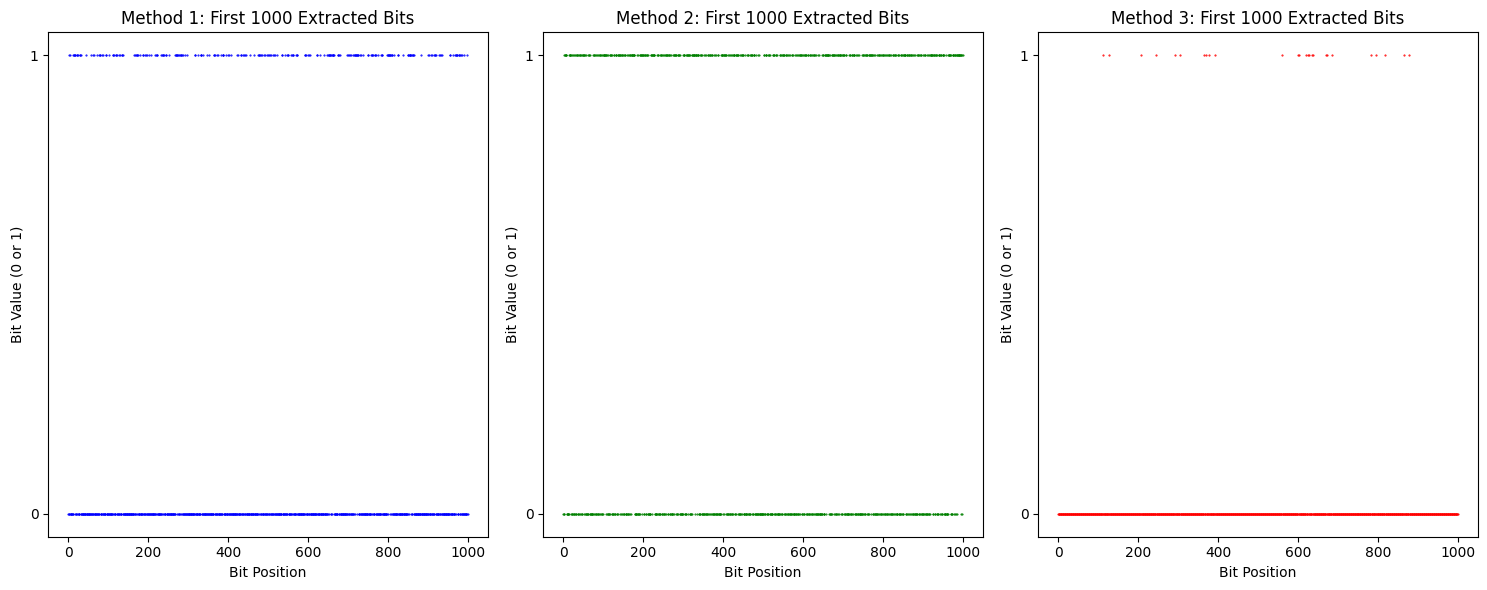

In [26]:
# Visual analysis of bit patterns
# Looking at the distribution of bits can reveal patterns
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
bit_positions = range(min(1000, len(extracted_bits_method1)))
bit_values = [extracted_bits_method1[i] for i in bit_positions]
plt.plot(bit_positions, bit_values, 'b.', markersize=1)
plt.title('Method 1: First 1000 Extracted Bits')
plt.xlabel('Bit Position')
plt.ylabel('Bit Value (0 or 1)')
plt.yticks([0, 1])

plt.subplot(1, 3, 2)
bit_positions = range(min(1000, len(extracted_bits_method2)))
bit_values = [extracted_bits_method2[i] for i in bit_positions]
plt.plot(bit_positions, bit_values, 'g.', markersize=1)
plt.title('Method 2: First 1000 Extracted Bits')
plt.xlabel('Bit Position')
plt.ylabel('Bit Value (0 or 1)')
plt.yticks([0, 1])

plt.subplot(1, 3, 3)
bit_positions = range(min(1000, len(extracted_bits_method3)))
bit_values = [extracted_bits_method3[i] for i in bit_positions]
plt.plot(bit_positions, bit_values, 'r.', markersize=1)
plt.title('Method 3: First 1000 Extracted Bits')
plt.xlabel('Bit Position')
plt.ylabel('Bit Value (0 or 1)')
plt.yticks([0, 1])

plt.tight_layout()
plt.savefig('extracted_bits_distribution.png')
plt.show()

In [27]:
# For Method 2 (based on coefficient changes), analyze groups of 8 bits
if len(extracted_bits_method2) >= 80:
    print("\nAnalyzing bit patterns in Method 2:")
    
    # Display the first 10 bytes as binary
    for i in range(10):
        if i*8+7 < len(extracted_bits_method2):
            byte_bits = extracted_bits_method2[i*8:i*8+8]
            byte_str = ''.join(map(str, byte_bits))
            byte_val = int(byte_str, 2)
            char = chr(byte_val) if 32 <= byte_val <= 126 else '.'
            print(f"Byte {i}: {byte_str} = {byte_val} (ASCII: {char})")


Analyzing bit patterns in Method 2:
Byte 0: 00101111 = 47 (ASCII: /)
Byte 1: 10000010 = 130 (ASCII: .)
Byte 2: 11101010 = 234 (ASCII: .)
Byte 3: 10100010 = 162 (ASCII: .)
Byte 4: 01111001 = 121 (ASCII: y)
Byte 5: 00110100 = 52 (ASCII: 4)
Byte 6: 11111010 = 250 (ASCII: .)
Byte 7: 01000100 = 68 (ASCII: D)
Byte 8: 11010000 = 208 (ASCII: .)
Byte 9: 00010111 = 23 (ASCII: .)


In [28]:
# Summary of findings
print("\n=== SUMMARY OF FINDINGS ===")
print(f"Analyzed stego image: {os.path.basename(stego_path)}")
print(f"Number of significantly modified DCT coefficients: {len(significant_diffs)}")
print(f"Method 1 extracted {len(extracted_bytes_method1)} bytes")
print(f"Method 2 extracted {len(extracted_bytes_method2)} bytes")
print(f"Method 3 extracted {len(extracted_bytes_method3)} bytes")
print("\nCheck the extracted_outputs folder for the complete extracted data.")


=== SUMMARY OF FINDINGS ===
Analyzed stego image: 00001.jpg
Number of significantly modified DCT coefficients: 162398
Method 1 extracted 25508 bytes
Method 2 extracted 20299 bytes
Method 3 extracted 5846 bytes

Check the extracted_outputs folder for the complete extracted data.


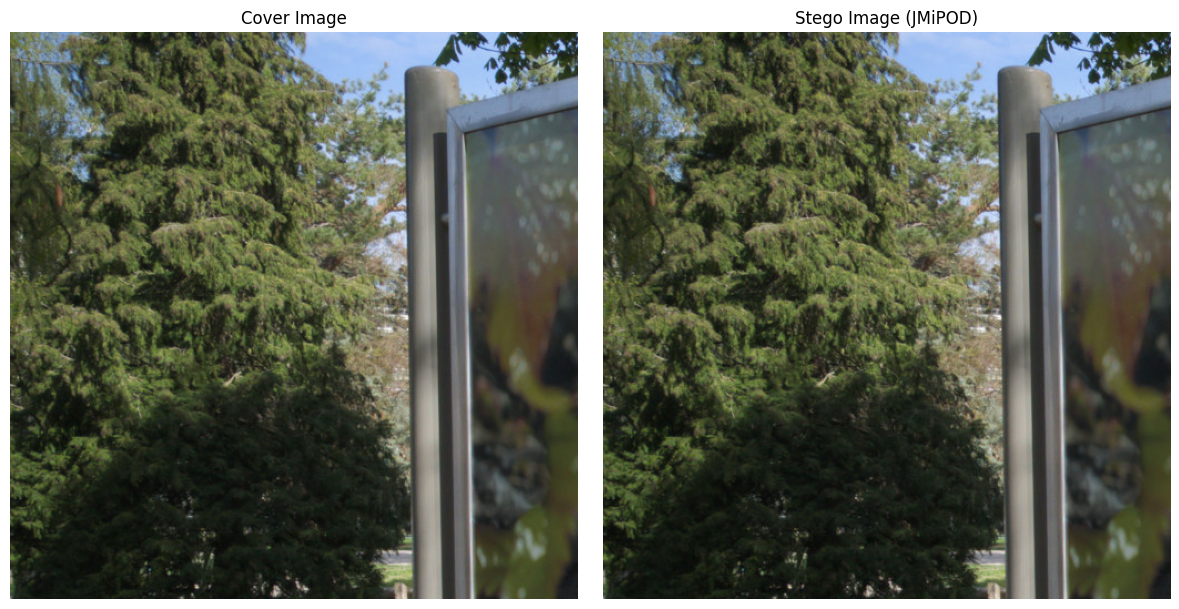

Creating dataset...
Dataset size: 998 images
Using device: cpu
Training model...


Epoch 1/3 - Validation: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 1/3:
  Train Loss: 21.5537
  Val Loss: 0.7604
  Accuracy: 0.4700
  Precision: 0.4366
  Recall: 0.7045


Epoch 2/3 - Validation: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 2/3:
  Train Loss: 0.7024
  Val Loss: 0.6983
  Accuracy: 0.4400
  Precision: 0.4394
  Recall: 0.9886


Epoch 3/3 - Validation: 100%|██████████| 13/13 [00:26<00:00,  2.08s/it]


Epoch 3/3:
  Train Loss: 0.6930
  Val Loss: 0.6987
  Accuracy: 0.4400
  Precision: 0.4400
  Recall: 1.0000
Model saved to /kaggle/working/deep_steganalysis_model.pth
Cover image probability: 0.5230
Stego image probability: 0.5230


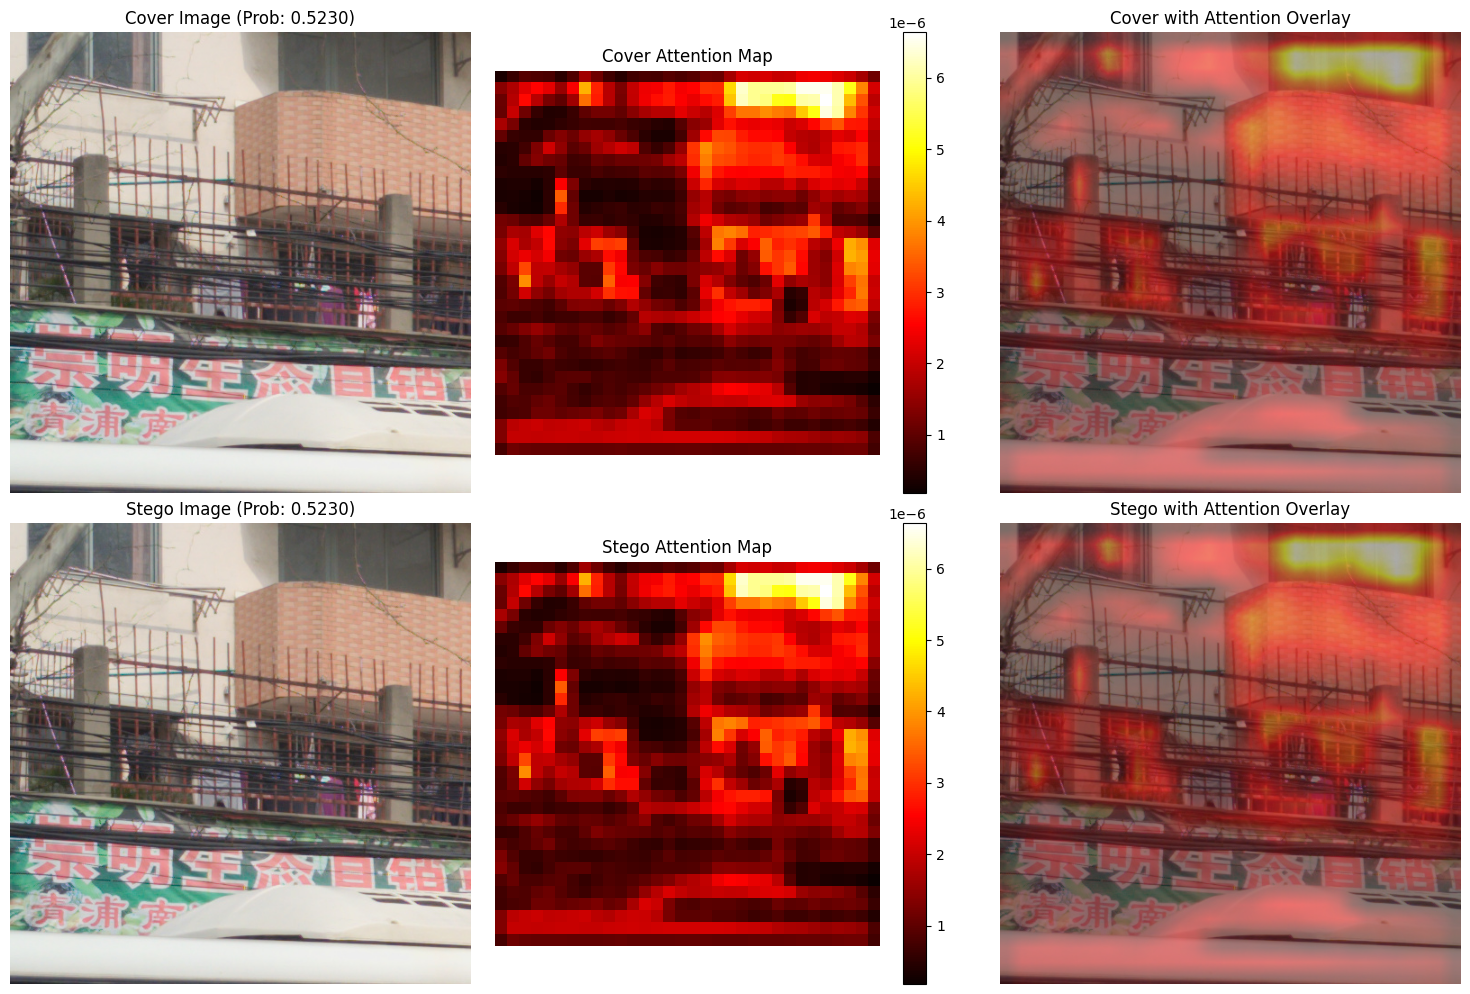

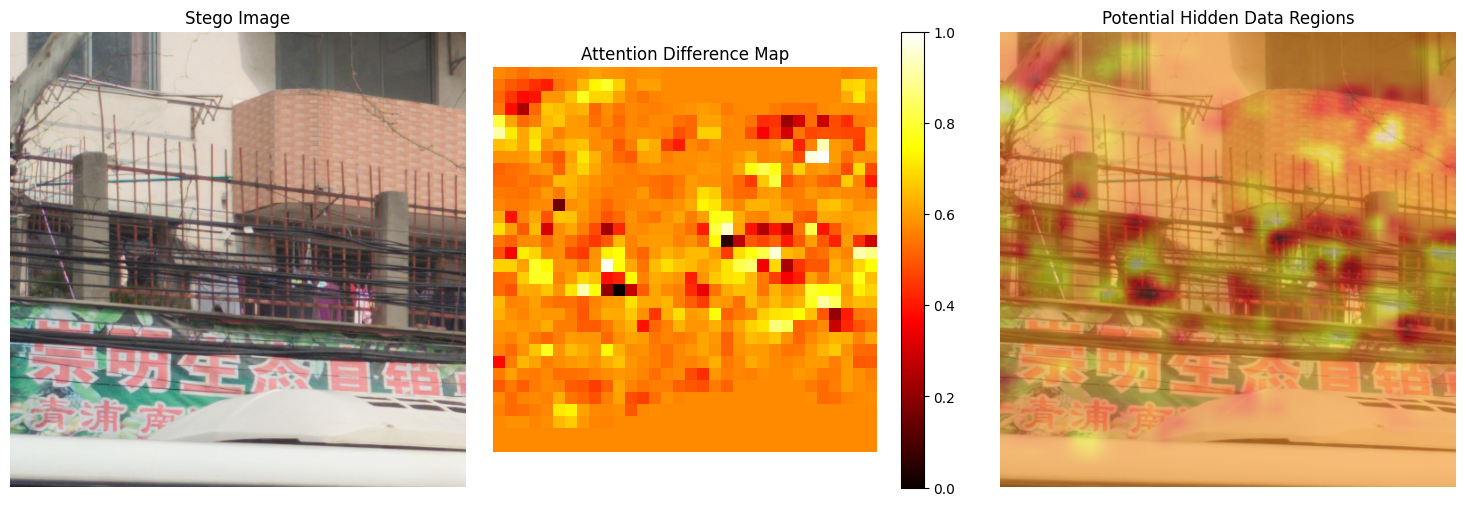

Deep learning steganalysis complete!


In [32]:
# Import necessary libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm

# Set up paths
BASE_PATH = "/kaggle/input/alaska2-image-steganalysis"
OUTPUT_PATH = "/kaggle/working"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Display example images
cover_path = os.path.join(BASE_PATH, 'Cover', '00001.jpg')
stego_path = os.path.join(BASE_PATH, 'JMiPOD', '00001.jpg')

cover_img = Image.open(cover_path)
stego_img = Image.open(stego_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cover_img)
plt.title('Cover Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stego_img)
plt.title('Stego Image (JMiPOD)')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'image_comparison.png'))
plt.show()

# Define a custom dataset for deep learning
class SteganalysisDataset(Dataset):
    def __init__(self, base_path, max_samples=1000, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Add cover images (label 0)
        cover_dir = os.path.join(base_path, 'Cover')
        cover_files = sorted(os.listdir(cover_dir))[:max_samples]
        
        for file in cover_files:
            self.images.append(os.path.join(cover_dir, file))
            self.labels.append(0)
        
        # Add stego images (label 1) - equal numbers from each algorithm
        stego_per_algo = max_samples // 3
        for algo in ['JMiPOD', 'JUNIWARD', 'UERD']:
            algo_dir = os.path.join(base_path, algo)
            algo_files = sorted(os.listdir(algo_dir))[:stego_per_algo]
            
            for file in algo_files:
                self.images.append(os.path.join(algo_dir, file))
                self.labels.append(1)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Extract high-pass filtered features - better for steganalysis than raw pixels
        high_pass = self.extract_high_pass_features(img)
        
        # Apply transform if specified
        if self.transform:
            img_tensor = self.transform(img)
            high_pass_tensor = self.transform(high_pass)
        else:
            # Default transformations
            img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32) / 255.0
            high_pass_tensor = torch.tensor(high_pass.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        
        return {
            'image': img_tensor,
            'high_pass': high_pass_tensor,
            'label': torch.tensor(label, dtype=torch.float32)
        }
    
    def extract_high_pass_features(self, img):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply high-pass filters to enhance hidden data detection
        # SRM filters (Spatial Rich Models) are ideal for steganalysis
        # Simplified version with basic high-pass filters
        kernel1 = np.array([[-1, 2, -1], [2, -4, 2], [-1, 2, -1]])
        kernel2 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) - 1/9 * np.ones((3, 3))
        kernel3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        
        filtered1 = cv2.filter2D(gray, -1, kernel1)
        filtered2 = cv2.filter2D(gray, -1, kernel2)
        filtered3 = cv2.filter2D(gray, -1, kernel3)
        
        # Stack the filters to create a 3-channel high-pass representation
        high_pass = np.stack([filtered1, filtered2, filtered3], axis=2)
        
        return high_pass

# Create data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
print("Creating dataset...")
dataset = SteganalysisDataset(BASE_PATH, max_samples=500, transform=transform)
print(f"Dataset size: {len(dataset)} images")

# Split into train/validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# CNN with attention mechanism for steganalysis
class SteganalysisNet(nn.Module):
    def __init__(self):
        super(SteganalysisNet, self).__init__()
        
        # Feature extraction for regular image
        self.conv1_img = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_img = nn.BatchNorm2d(32)
        self.conv2_img = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_img = nn.BatchNorm2d(64)
        self.conv3_img = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_img = nn.BatchNorm2d(128)
        
        # Feature extraction for high-pass filtered image
        self.conv1_hp = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_hp = nn.BatchNorm2d(32)
        self.conv2_hp = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_hp = nn.BatchNorm2d(64)
        self.conv3_hp = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_hp = nn.BatchNorm2d(128)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Classification layers
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        
        # Pooling and activation
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img, high_pass):
        # Process regular image
        x1 = self.relu(self.bn1_img(self.conv1_img(img)))
        x1 = self.pool(x1)
        x1 = self.relu(self.bn2_img(self.conv2_img(x1)))
        x1 = self.pool(x1)
        x1 = self.relu(self.bn3_img(self.conv3_img(x1)))
        x1 = self.pool(x1)
        
        # Process high-pass filtered image
        x2 = self.relu(self.bn1_hp(self.conv1_hp(high_pass)))
        x2 = self.pool(x2)
        x2 = self.relu(self.bn2_hp(self.conv2_hp(x2)))
        x2 = self.pool(x2)
        x2 = self.relu(self.bn3_hp(self.conv3_hp(x2)))
        x2 = self.pool(x2)
        
        # Concatenate features
        x = torch.cat((x1, x2), dim=1)
        
        # Apply attention
        attention_weights = self.attention(x)
        x = x * attention_weights
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        
        return x

# Initialize model, loss function, and optimizer
model = SteganalysisNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train on CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Train the model
num_epochs = 3
print("Training model...")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = batch['image'].to(device)
        high_pass = batch['high_pass'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, high_pass)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = batch['image'].to(device)
            high_pass = batch['high_pass'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            
            outputs = model(images, high_pass)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            # Store predictions and labels for metrics
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    val_loss /= len(val_loader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

# Save the trained model
torch.save(model.state_dict(), os.path.join(OUTPUT_PATH, 'deep_steganalysis_model.pth'))
print(f"Model saved to {os.path.join(OUTPUT_PATH, 'deep_steganalysis_model.pth')}")

# Function to extract features from a trained model
def extract_features(model, img_path, device):
    """Extract features from the trained model to help identify modified areas"""
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image to match what the model expects (256x256)
    img_resized = cv2.resize(img, (256, 256))
    
    # Extract high-pass features
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    kernel1 = np.array([[-1, 2, -1], [2, -4, 2], [-1, 2, -1]])
    kernel2 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) - 1/9 * np.ones((3, 3))
    kernel3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    
    filtered1 = cv2.filter2D(gray, -1, kernel1)
    filtered2 = cv2.filter2D(gray, -1, kernel2)
    filtered3 = cv2.filter2D(gray, -1, kernel3)
    
    high_pass = np.stack([filtered1, filtered2, filtered3], axis=2)
    
    # Convert to tensors
    img_tensor = torch.tensor(img_resized.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
    high_pass_tensor = torch.tensor(high_pass.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
    
    # Move to device
    img_tensor = img_tensor.to(device)
    high_pass_tensor = high_pass_tensor.to(device)
    
    # Get model features
    with torch.no_grad():
        # Process regular image
        x1 = model.relu(model.bn1_img(model.conv1_img(img_tensor)))
        x1 = model.pool(x1)
        x1 = model.relu(model.bn2_img(model.conv2_img(x1)))
        x1 = model.pool(x1)
        x1 = model.relu(model.bn3_img(model.conv3_img(x1)))
        x1 = model.pool(x1)
        
        # Process high-pass filtered image
        x2 = model.relu(model.bn1_hp(model.conv1_hp(high_pass_tensor)))
        x2 = model.pool(x2)
        x2 = model.relu(model.bn2_hp(model.conv2_hp(x2)))
        x2 = model.pool(x2)
        x2 = model.relu(model.bn3_hp(model.conv3_hp(x2)))
        x2 = model.pool(x2)
        
        # Concatenate features
        combined = torch.cat((x1, x2), dim=1)
        
        # Get attention weights
        attention_weights = model.attention(combined)
        
        # Get final features with attention applied
        features = combined * attention_weights
    
    return features.cpu().numpy()[0], attention_weights.cpu().numpy()[0]

# Test the model and extract attention maps for visualization
stego_test_path = os.path.join(BASE_PATH, 'JMiPOD', '00015.jpg')
cover_test_path = os.path.join(BASE_PATH, 'Cover', '00015.jpg')

# Function to predict if an image contains steganography
def predict_stego(model, img_path, device):
    """Predict if an image contains steganography"""
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image to match what the model expects (256x256)
    img_resized = cv2.resize(img, (256, 256))
    
    # Extract high-pass features
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    kernel1 = np.array([[-1, 2, -1], [2, -4, 2], [-1, 2, -1]])
    kernel2 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) - 1/9 * np.ones((3, 3))
    kernel3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    
    filtered1 = cv2.filter2D(gray, -1, kernel1)
    filtered2 = cv2.filter2D(gray, -1, kernel2)
    filtered3 = cv2.filter2D(gray, -1, kernel3)
    
    high_pass = np.stack([filtered1, filtered2, filtered3], axis=2)
    
    # Convert to tensors
    img_tensor = torch.tensor(img_resized.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
    high_pass_tensor = torch.tensor(high_pass.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
    
    # Move to device
    img_tensor = img_tensor.to(device)
    high_pass_tensor = high_pass_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(img_tensor, high_pass_tensor)
        stego_probability = prediction.item()
    
    return stego_probability, img

# Make predictions
stego_prob, stego_img = predict_stego(model, stego_test_path, device)
cover_prob, cover_img = predict_stego(model, cover_test_path, device)

print(f"Cover image probability: {cover_prob:.4f}")
print(f"Stego image probability: {stego_prob:.4f}")

# Extract features and attention maps
stego_features, stego_attention = extract_features(model, stego_test_path, device)
cover_features, cover_attention = extract_features(model, cover_test_path, device)

# Visualize attention maps (areas the model focuses on to detect steganography)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cover_img)
plt.title(f'Cover Image (Prob: {cover_prob:.4f})')
plt.axis('off')

plt.subplot(2, 3, 2)
# Sum across channels for visualization
plt.imshow(np.sum(cover_attention, axis=0), cmap='hot')
plt.title('Cover Attention Map')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 3, 3)
# Overlay attention on image
attention_overlay = np.sum(cover_attention, axis=0)
attention_overlay = cv2.resize(attention_overlay, (cover_img.shape[1], cover_img.shape[0]))
attention_overlay = (attention_overlay - attention_overlay.min()) / (attention_overlay.max() - attention_overlay.min())
plt.imshow(cover_img)
plt.imshow(attention_overlay, alpha=0.5, cmap='hot')
plt.title('Cover with Attention Overlay')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(stego_img)
plt.title(f'Stego Image (Prob: {stego_prob:.4f})')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.sum(stego_attention, axis=0), cmap='hot')
plt.title('Stego Attention Map')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 3, 6)
attention_overlay = np.sum(stego_attention, axis=0)
attention_overlay = cv2.resize(attention_overlay, (stego_img.shape[1], stego_img.shape[0]))
attention_overlay = (attention_overlay - attention_overlay.min()) / (attention_overlay.max() - attention_overlay.min())
plt.imshow(stego_img)
plt.imshow(attention_overlay, alpha=0.5, cmap='hot')
plt.title('Stego with Attention Overlay')
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'attention_maps.png'))
plt.show()

# Calculate the difference in attention maps to identify potential regions with hidden data
attention_diff = np.sum(stego_attention, axis=0) - np.sum(cover_attention, axis=0)
attention_diff = (attention_diff - attention_diff.min()) / (attention_diff.max() - attention_diff.min())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(stego_img)
plt.title('Stego Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(attention_diff, cmap='hot')
plt.title('Attention Difference Map')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 3)
attention_diff_resized = cv2.resize(attention_diff, (stego_img.shape[1], stego_img.shape[0]))
plt.imshow(stego_img)
plt.imshow(attention_diff_resized, alpha=0.5, cmap='hot')
plt.title('Potential Hidden Data Regions')
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'hidden_data_regions.png'))
plt.show()

print("Deep learning steganalysis complete!")

In [40]:
pip install streamlit torch torchvision opencv-python-headless matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstal

In [52]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

# Path to your uploaded image inside the dataset folder
image_path = '/kaggle/input/hidden/group-2.png'  # Update this path

# Load and display image
img = Image.open(image_path)
img = img.resize((100, 100))  # Resize to match your model's input
img_array = np.array(img) / 255.0  # Normalize if your model was trained on normalized images
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class RefinedSteganalysisNet(nn.Module):
    def __init__(self):
        super(RefinedSteganalysisNet, self).__init__()
        
        # Enhanced Feature Extraction
        self.features = nn.Sequential(
            # First Block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth Block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Adaptive Pooling to standardize feature map size
        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Feature extraction
        features = self.features(x)
        
        # Adaptive pooling
        features = self.adaptive_pool(features)
        
        # Flatten
        features = features.view(features.size(0), -1)
        
        # Classify
        output = self.classifier(features)
        
        return output

class SteganalysisDataset(Dataset):
    def __init__(self, base_path, max_samples=2000, transform=None):
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        self.images = []
        self.labels = []
        
        # Balanced sampling
        stego_algos = ['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']
        samples_per_algo = max_samples // len(stego_algos)
        
        for algo in stego_algos:
            algo_path = os.path.join(base_path, algo)
            files = sorted(os.listdir(algo_path))[:samples_per_algo]
            
            for file in files:
                img_path = os.path.join(algo_path, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                self.images.append(img)
                # Label 0 for Cover, 1 for Stego
                self.labels.append(0 if algo == 'Cover' else 1)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        # Data Augmentation
        if np.random.random() < 0.3:
            # Random horizontal flip
            img = cv2.flip(img, 1)
        
        if np.random.random() < 0.2:
            # Random brightness adjustment
            img = cv2.convertScaleAbs(img, alpha=np.random.uniform(0.8, 1.2), beta=np.random.randint(-30, 30))
        
        # Transform
        img = self.transform(img)
        
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.float32)
        }

def train_steganalysis_model(base_path, num_epochs=15, batch_size=32, learning_rate=0.0001):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset
    dataset = SteganalysisDataset(base_path)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model, Loss, and Optimizer
    model = RefinedSteganalysisNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    # Training Loop
    best_val_accuracy = 0
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_preds, train_labels = [], []
        
        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Tracking
            train_losses.append(loss.item())
            train_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int).flatten())
            train_labels.extend(labels.cpu().numpy().flatten())
        
        # Validation Phase
        model.eval()
        val_losses = []
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].unsqueeze(1).to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_losses.append(loss.item())
                val_preds.extend((outputs.cpu().numpy() > 0.5).astype(int).flatten())
                val_labels.extend(labels.cpu().numpy().flatten())
        
        # Compute metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds)
        val_recall = recall_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {np.mean(train_losses):.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {np.mean(val_losses):.4f}, Val Accuracy: {val_accuracy:.4f}')
        print(f'Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')
        print(f'Val F1 Score: {val_f1:.4f}')
        print('-' * 50)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_steganalysis_model.pth')
            print(f'Saved best model with accuracy: {best_val_accuracy:.4f}')
        
        # Update learning rate
        scheduler.step(val_accuracy)
    
    return model

# Main execution
if __name__ == '__main__':
    base_path = './alaska2-image-steganalysis'
    trained_model = train_steganalysis_model(base_path)